In [2]:
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(2)

In [3]:
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.layers import Input, Conv2D, Dense
from tensorflow.keras.layers import Reshape, Layer, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import initializers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as K
import numpy as np
import tensorflow as tf
import cv2
import os
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pylab as plt
import cv2   
import os
from google.colab.patches import cv2_imshow # for image display
import pandas as pd

In [4]:
input_shape = [28, 28, 1]
dimA, dimB, n_channel = input_shape
tot_n_pixels = dimA * dimB * n_channel

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(-1, dimA, dimB, 1).astype('float32') / 255.0 # normalize the training set
x_test = x_test.reshape(-1, dimA, dimB, 1).astype('float32') / 255.0 # normalize the test set

y_train = to_categorical(y_train.astype('float32'))
y_test = to_categorical(y_test.astype('float32'))

X = x_train
Y = y_train

11501568/11490434 [==============================] - 0s 0us/step


In [5]:
# pass the reshaped output through a non-linear squash function to ensure that the length of each vector is between 0 and 1
def squash(output_vector, axis=-1):
    # take norm of input vectors
    norm = tf.reduce_sum(tf.square(output_vector), axis, keepdims=True) 

    # use the formula for non-linear function to return squashed output
    return output_vector * norm / ((1 + norm) * tf.sqrt(norm + 1.0e-10))

In [6]:
# input from the digit capsule is masked with the original or actual label. This is done to ensure that the decoder is trained on the correct digit capsule.
class MaskingLayer(Layer):
    def call(self, inputs, **kwargs):
        input, mask = inputs
        return K.batch_dot(input, mask, 1)

    def compute_output_shape(self, input_shape):
        *_, output_shape = input_shape[0]
        return (None, output_shape)

In [7]:
# the primary capsule layer performs the following: conv, reshape, and lambda
def PrimaryCapsule(n_vector, n_channel, n_kernel_size, n_stride, padding='valid'):
    def builder(inputs):
        output = Conv2D(filters=n_vector * n_channel, kernel_size=n_kernel_size, strides=n_stride, padding=padding)(inputs)
        output = Reshape( target_shape=[-1, n_vector], name='primary_capsule_reshape')(output) # reshape to the required number of capsules and vector per capsule
        return Lambda(squash, name='primary_capsule_squash')(output) # squash the reshaped output to make length of vector b/w 0 and 1
    return builder

In [8]:
class DigitCapsuleLayer(Layer):
    def __init__(self, n_capsule, n_vec, n_routing, **kwargs):
        super(DigitCapsuleLayer, self).__init__(**kwargs)
        self.n_capsule = n_capsule
        self.n_vector = n_vec
        self.n_routing = n_routing
        self.kernel_initializer = initializers.get('he_normal')
        self.bias_initializer = initializers.get('zeros')

    def build(self, input_shape): # input_shape is a 4D tensor
        _, self.input_n_capsule, self.input_n_vector, *_ = input_shape
        #self.W = self.add_weight(shape=[self.input_n_capsule, self.n_capsule, self.input_n_vector, self.n_vector], initializer=self.kernel_initializer, name='W')
        #self.W = self.add_weight(shape=[self.n_capsule, self.input_n_capsule, self.input_n_vector, self.n_vector], initializer=self.kernel_initializer, name='W')
        self.W = self.add_weight(shape=[self.n_capsule, self.input_n_capsule, self.n_vector, self.input_n_vector], initializer=self.kernel_initializer, name='W')
        self.bias = self.add_weight(shape=[1, self.input_n_capsule, self.n_capsule, 1, 1], initializer=self.bias_initializer, name='bias', trainable=False)
        self.built = True

    def call(self, inputs, training=None):
        # Expand the input in axis=1, tile in that axis to num_capsule, and 
        # expands another axis at the end to prepare the multiplication with W.
        #  inputs.shape=[None, input_num_capsule, input_dim_capsule]
        #  inputs_expand.shape=[None, 1, input_num_capsule, input_dim_capsule]
        #  inputs_tiled.shape=[None, num_capsule, input_num_capsule, 
        #                            input_dim_capsule, 1]
        inputs_expand = tf.expand_dims(inputs, 1)
        inputs_tiled  = tf.tile(inputs_expand, [1, self.n_capsule, 1, 1])
        inputs_tiled  = tf.expand_dims(inputs_tiled, 4)

        # Compute `W * inputs` by scanning inputs_tiled on dimension 0 (map_fn).
        # - Use matmul (without transposing any element). Note the order!
        # Thus:
        #  x.shape=[num_capsule, input_num_capsule, input_dim_capsule, 1]
        #  W.shape=[num_capsule, input_num_capsule, dim_capsule,input_dim_capsule]
        # Regard the first two dimensions as `batch` dimension,
        # then matmul: [dim_capsule, input_dim_capsule] x [input_dim_capsule, 1]-> 
        #              [dim_capsule, 1].
        #  inputs_hat.shape=[None, num_capsule, input_num_capsule, dim_capsule, 1]
        
        inputs_hat = tf.map_fn(lambda x: tf.matmul(self.W, x), elems=inputs_tiled)     

        # Begin: Routing algorithm ----------------------------------------------#
        # The prior for coupling coefficient, initialized as zeros.
        #  b.shape = [None, self.num_capsule, self.input_num_capsule, 1, 1].
        b = tf.zeros(shape=[tf.shape(inputs_hat)[0], self.n_capsule, 
                            self.input_n_capsule, 1, 1])

        assert self.n_routing > 0, 'The routings should be > 0.'
        for i in range(self.n_routing):
            # Apply softmax to the axis with `num_capsule`
            #  c.shape=[batch_size, num_capsule, input_num_capsule, 1, 1]
            c = layers.Softmax(axis=1)(b)

            # Compute the weighted sum of all the predicted output vectors.
            #  c.shape =  [batch_size, num_capsule, input_num_capsule, 1, 1]
            #  inputs_hat.shape=[None, num_capsule, input_num_capsule,dim_capsule,1]
            # The function `multiply` will broadcast axis=3 in c to dim_capsule.
            #  outputs.shape=[None, num_capsule, input_num_capsule, dim_capsule, 1]
            # Then sum along the input_num_capsule
            #  outputs.shape=[None, num_capsule, 1, dim_capsule, 1]
            # Then apply squash along the dim_capsule
            outputs = tf.multiply(c, inputs_hat)
            outputs = tf.reduce_sum(outputs, axis=2, keepdims=True)
            outputs = squash(outputs, axis=-2)  # [None, 10, 1, 16, 1]

            if i < self.n_routing - 1:
                # Update the prior b.
                #  outputs.shape =  [None, num_capsule, 1, dim_capsule, 1]
                #  inputs_hat.shape=[None,num_capsule,input_num_capsule,dim_capsule,1]
                # Multiply the outputs with the weighted_inputs (inputs_hat) and add  
                # it to the prior b.  
                outputs_tiled = tf.tile(outputs, [1, 1, self.input_n_capsule, 1, 1])
                agreement = tf.matmul(inputs_hat, outputs_tiled, transpose_a=True)
                b = tf.add(b, agreement)

        # End: Routing algorithm ------------------------------------------------#
        # Squeeze the outputs to remove useless axis:
        #  From  --> outputs.shape=[None, num_capsule, 1, dim_capsule, 1]
        #  To    --> outputs.shape=[None, num_capsule,    dim_capsule]
        outputs = tf.squeeze(outputs, [2, 4])
        return outputs

    def compute_output_shape(self, input_shape):
        # output current layer capsules
        return (None, self.n_capsule, self.n_vector)

In [9]:
class LengthLayer(Layer):
    def call(self, inputs, **kwargs):
        return tf.sqrt(tf.reduce_sum(tf.square(inputs), axis=-1, keepdims=False))

    def compute_output_shape(self, input_shape):
        *output_shape, _ = input_shape
        return tuple(output_shape)

In [10]:
# probabilistic loss function used for classifying digits image.
def margin_loss(y_ground_truth, y_prediction):
    _m_plus = 0.9
    _m_minus = 0.1
    _lambda = 0.5
    L = y_ground_truth * tf.square(tf.maximum(0., _m_plus - y_prediction)) + _lambda * ( 1 - y_ground_truth) * tf.square(tf.maximum(0., y_prediction - _m_minus))
    return tf.reduce_mean(tf.reduce_sum(L, axis=1))

In [11]:
# encoder network
n_class = 10
n_routing = 7

x = Input(shape=input_shape) # input for the encoder network
conv1 = Conv2D(filters=256, kernel_size=5, strides=1, padding='valid', activation='relu', name='conv1')(x)
primary_capsule = PrimaryCapsule(n_vector=8, n_channel=32, n_kernel_size=9, n_stride=2)(conv1)
digit_capsule = DigitCapsuleLayer(n_capsule=n_class, n_vec=16, n_routing=n_routing, name='digit_capsule')(primary_capsule)
output_capsule = LengthLayer(name='output_capsule')(digit_capsule)

In [12]:
# decoder network to reconstruct the input image
mask_input = Input(shape=(n_class, )) # input for the digits capsule layer
mask = MaskingLayer()([digit_capsule, mask_input])  # two inputs - the digit capsule and the masked input
dec = Dense(512, activation='relu')(mask)
dec = Dense(1024, activation='relu')(dec)
dec = Dense(tot_n_pixels, activation='sigmoid')(dec) # reconstruct the input image
dec = Reshape(input_shape)(dec)

In [13]:
# compile the model
model = Model([x, mask_input], [output_capsule, dec])
model.compile(optimizer=optimizers.Adam(lr=0.0001), loss=[ margin_loss, 'mae' ], metrics=[ margin_loss, 'mae', 'accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [14]:
# train the model
BS = 32
EPOCHS = 10
H = model.fit([X, Y], [Y, X], steps_per_epoch=int(Y.shape[0] / BS), batch_size=BS, epochs=EPOCHS) 

Epoch 1/10
1875/1875 [==============================] - 332s 168ms/step - loss: 0.2256 - output_capsule_loss: 0.0918 - reshape_loss: 0.1338 - output_capsule_margin_loss: 0.0918 - output_capsule_mae: 0.1003 - output_capsule_accuracy: 0.9200 - reshape_margin_loss: 1.9545 - reshape_mae: 0.1338 - reshape_accuracy: 0.7995
Epoch 2/10
1875/1875 [==============================] - 317s 169ms/step - loss: 0.1242 - output_capsule_loss: 0.0259 - reshape_loss: 0.0984 - output_capsule_margin_loss: 0.0259 - output_capsule_mae: 0.0675 - output_capsule_accuracy: 0.9813 - reshape_margin_loss: 1.6880 - reshape_mae: 0.0984 - reshape_accuracy: 0.8009
Epoch 3/10
1875/1875 [==============================] - 316s 169ms/step - loss: 0.1096 - output_capsule_loss: 0.0180 - reshape_loss: 0.0916 - output_capsule_margin_loss: 0.0180 - output_capsule_mae: 0.0612 - output_capsule_accuracy: 0.9876 - reshape_margin_loss: 1.6148 - reshape_mae: 0.0916 - reshape_accuracy: 0.8032
Epoch 4/10
1875/1875 [=====================

In [15]:
from sklearn.metrics import classification_report, precision_score, recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

# evaluate the model
label_predicted, image_predicted = model.predict([x_test, y_test])

# convert the predicted label to categorical values so that we can calculate the performance metrics
pred_categorical = []
actual_categorical = []  
for i in range(0, len(label_predicted)):
  pred_categorical.append(np.argmax(label_predicted[i])) 
  actual_categorical.append(np.argmax(y_test[i]))

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(actual_categorical, pred_categorical)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(actual_categorical, pred_categorical, average='micro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(actual_categorical, pred_categorical, average='micro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(actual_categorical, pred_categorical, average='micro')
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(actual_categorical, pred_categorical)
print('Cohens kappa: %f' % kappa)

# confusion matrix
matrix = confusion_matrix(actual_categorical, pred_categorical)
print(matrix)

Accuracy: 0.992900
Precision: 0.992900
Recall: 0.992900
F1 score: 0.992900
Cohens kappa: 0.992108
[[ 980    0    0    0    0    0    0    0    0    0]
 [   0 1133    0    1    0    0    0    1    0    0]
 [   1    0 1026    1    0    0    0    3    1    0]
 [   0    0    1 1007    0    2    0    0    0    0]
 [   1    0    0    0  974    0    4    0    0    3]
 [   2    0    0    9    1  878    1    0    1    0]
 [   8    2    1    0    1    0  945    0    1    0]
 [   0    2    3    1    0    0    0 1019    1    2]
 [   1    0    0    1    0    0    0    1  969    2]
 [   2    1    0    2    5    0    0    0    1  998]]


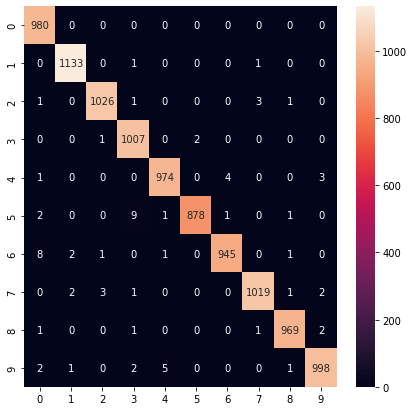

In [21]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(matrix, index=["0", "1", "2", "3", "4", "5", "6", "7","8", "9"], 
                     columns=["0", "1", "2", "3", "4", "5", "6", "7","8", "9"]) 

plt.figure(figsize = (7,7))
sn.heatmap(df_cm, fmt='.5g', annot=True)

In [17]:
print(classification_report(actual_categorical, pred_categorical))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       980
           1       1.00      1.00      1.00      1135
           2       1.00      0.99      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       1.00      0.98      0.99       892
           6       0.99      0.99      0.99       958
           7       1.00      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



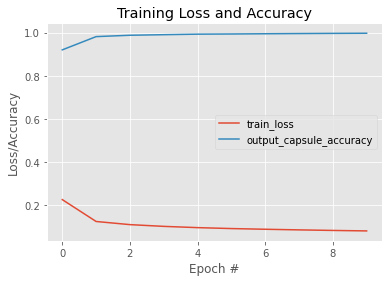

In [22]:
# evaluate the network
from sklearn.metrics import classification_report
%matplotlib inline 
import matplotlib.pylab as plt

N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
#plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["output_capsule_accuracy"], label="output_capsule_accuracy")
#plt.plot(N, H.history["val_output_capsule_accuracy"], label="val_output_capsule_accuracy")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

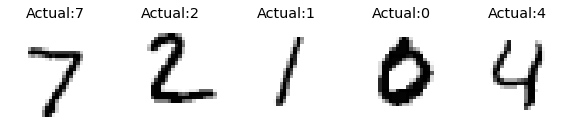

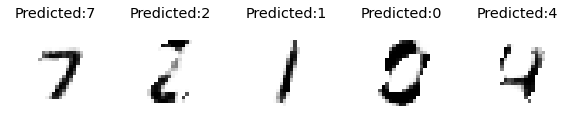

In [26]:
# visualize the predicted images

n_samples = 5
plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    sample_image = x_test[index].reshape(28, 28)
    plt.imshow(sample_image, cmap="binary")
    #plt.title("Label:" + str(y_test[index]))
    plt.title("Actual:" + str(np.argmax(y_test[index])))
    plt.axis("off")

plt.show()

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    sample_image = image_predicted[index].reshape(28, 28)
    plt.imshow(sample_image, cmap="binary")
    plt.title("Predicted:" + str(np.argmax(label_predicted[index])))
    plt.axis("off")

plt.show()